In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from math import floor
from elephant.spike_train_generation import homogeneous_poisson_process
import elephant.conversion as conv
import neo as n
from quantities import Hz, s, ms

from infomap import Infomap, MultilayerNode

In [2]:
def normalized_cross_corr(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
    y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))

    normalization = x_cov_std * y_cov_std
        

    unnormalized_correlation = np.correlate(x - x_mean, y - y_mean, 'full')
    
    corr_array = unnormalized_correlation/normalization

    return(corr_array)

def max_norm_cross_corr(x1, x2):
    
    correlation= normalized_cross_corr(x1, x2)
    
    lag = abs(correlation).argmax() - len(x1)+1
    
    max_corr = max(abs(correlation))
    
    return(max_corr, lag)

def cross_correlation_matrix(data):
    #input: n x t matrix where n is the number of rois and t is the duration of the time series
    #return: n x n symmetric cross correlation matrix, nxn uppertriangular cross correlation matrix and lag matrix
    n, t = data.shape
    X = np.zeros((n,n))
    lag = np.zeros((n,n))
    
    for i in range(n-1):
        for j in range(i+1,n):
            X[i][j],lag[i][j] = max_norm_cross_corr(data[i,:],data[j,:])
    X[np.isnan(X)] = 0
    lag[np.isnan(lag)] = 0
    
    X_full = X + X.T
    lag = lag + lag.T
    return(X_full, X, lag)

In [3]:
def bin_time_series(array, binsize, gaussian = True, **kwargs):
    #input: nxt matrix 
    #returns: binned time series i.e. l x n x binsize
    
    n = array.shape[0] # number of neurons
    totalsize = array.shape[1] # total duration of spikes
    gauss_array = np.zeros((n,totalsize))
    l = int(totalsize/binsize) # number of resulting layers
    if gaussian:
        for i in range(n):
            gauss_array[i] = gaussian_filter(array[i],kwargs['sigma'])
    else: gauss_array = array
    A = np.zeros((l,n,binsize))
    for i in range(l):
        A[i] = gauss_array[:,i*binsize:(i+1)*binsize]
    return(A)

def binarize(array):
    n,t = array.shape
    binary_spikes = np.zeros((n,t), dtype = bool)
    for i in range(n):
        for j in range(t):
            if array[i][j] == 0: pass
            else: binary_spikes[i][j] = True
    return(binary_spikes)

def gaussian_filter(array,sigma):
    #sigma=0.25==gaussian kernel with length 3
    #sigma=0.5==gaussian kernel with length 5
    #sigma=1==gaussian kernel with length 9
    return(gaussian_filter1d(array,sigma))

def jitter(spike, k):
    #jittering the given spike train
    jittered = np.zeros(spike.shape)
    for i in np.nonzero(spike)[1]:
        jitt = random.randint(-k,k)
        try:jittered[0,i+jitt] = 1
        except:jittered[0,i] = 1
    return(jittered)

## 1) Create spike trains via a Poisson Process*.
### * We define 2 layers and 2 and 4 communities of fixed size in layer 1 and layer 2 respectively. We jitter the master spike in each community(shift the spike right or left randomly with standard deviation of 5 frames) to create a syncronized neuronal community.

In [4]:
spike_rate = [10, 30] # spike rate per layer i.e. every community in the respective layer has this spike rate
comm_sizes = [[30,30],[15,15,15,15]] # community sizes at every layer
num_neurons = int(sum(comm_sizes[0])) #total number of neurons
bin_size = 1000.0 # in frames, in every bin_size, a community activity occurs(splitting, growing, merging etc..)
seconds = len(spike_rate)
total_duration = int(seconds*bin_size)
window_size = 1000 # size, in frames, each adjacency matrix correspond to. better to be equal to bin_size 
standard_dev = 1.2 # for gaussian kernel
k = 5 #for jittering the spikes
layers = int(total_duration/window_size)

In [5]:
spikes = np.zeros((num_neurons, total_duration))
for s in range(seconds):
    neuron_count = 0
    for i,e in enumerate(comm_sizes[s]):
        initial_master = homogeneous_poisson_process(rate = spike_rate[s]*Hz, t_start = s*(bin_size)*ms, t_stop = (s+1)*bin_size*ms, as_array=True)
        master_spikes = np.zeros((1,total_duration))
    
        for j,f in enumerate(initial_master):
            master_spikes[0][int(f)] = 1

        for j in range(e):
            spikes[neuron_count+j][int(s*bin_size):int((s+1)*bin_size)] = jitter(master_spikes[:,int(s*bin_size):int((s+1)*bin_size)], k)
        neuron_count = neuron_count + e

## 2) Display spikes

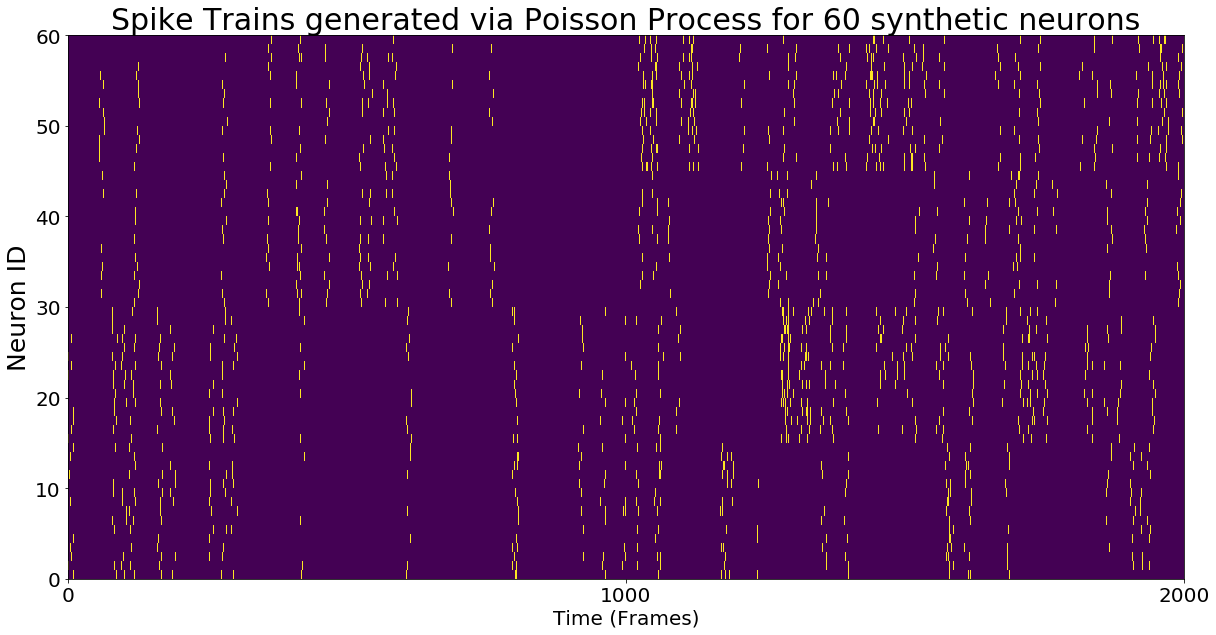

In [6]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.imshow(spikes, origin = 'lower', interpolation='nearest', aspect='auto',  extent = [0,total_duration,0,num_neurons])
ax.set_title('Spike Trains generated via Poisson Process for %d synthetic neurons'%num_neurons, fontsize= 30)
ax.set_xlabel('TIME (in Miliseconds)', fontsize = 20)
ax.set_xticks([j*1000 for j in range(int(total_duration/1000)+1)])
ax.set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
ax.set_ylabel('Neuron ID', fontsize = 25)
ax.set_xlabel('Time (Frames)', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)

## 3) Divide the time series in half each having length 1000 frames & widen the spikes by multipyling each spike with a gaussian kernel with some standard deviation to increase the cross-correlation in 4)

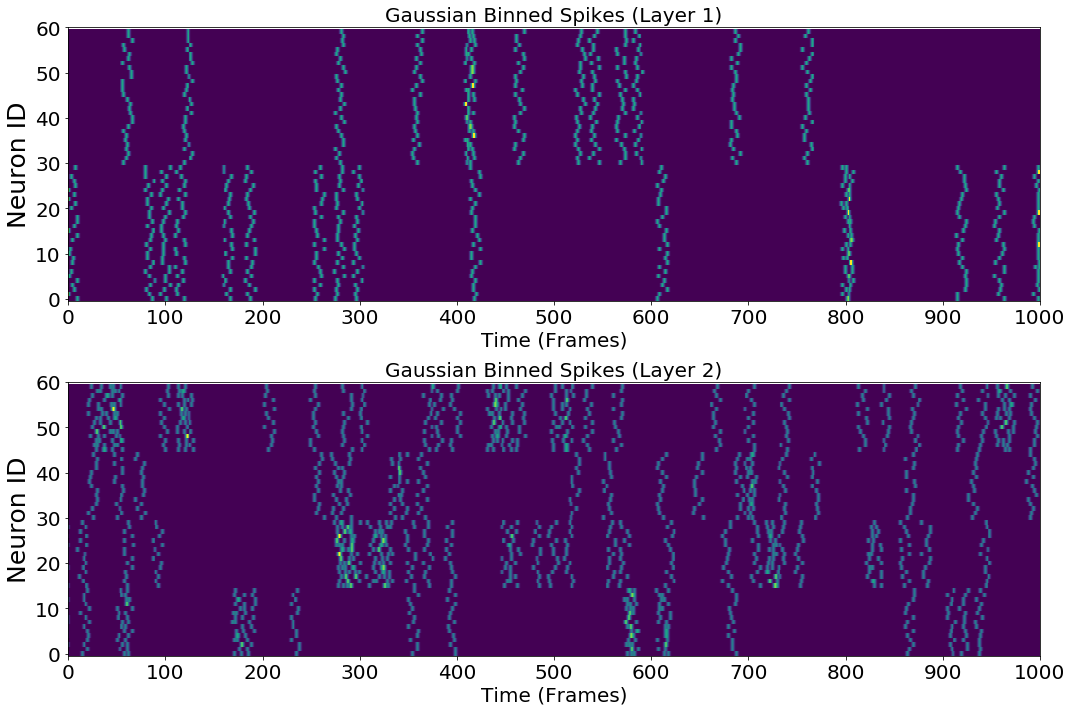

In [7]:
binned_spikes = bin_time_series(spikes, window_size, gaussian = True, sigma = standard_dev)
fig,ax = plt.subplots(layers,1,figsize=(15,10))
for i in range(layers):
    ax[i].imshow(binned_spikes[i], origin = 'lower', interpolation='nearest', aspect='auto')
    ax[i].set_title('Gaussian Binned Spikes (Layer %d)'%(i+1), fontsize = 20)
    ax[i].set_xlabel('TIME (in Miliseconds)', fontsize = 20)
    ax[i].set_xticks([j*100 for j in range(11)])
    ax[i].set_yticks([j*10 for j in range(int(num_neurons/10)+1)])
    ax[i].set_ylabel('Neuron ID', fontsize = 25)
    ax[i].set_xlabel('Time (Frames)', fontsize = 20)
    ax[i].tick_params(axis = 'both', labelsize = 20)
plt.tight_layout()

## 4) Calculate the maximum positive cross correlation betwen pairs of neurons to create adjacency matrices

In [8]:
##create cross-correlation matrices that are the adjacency matrices of the network at each layer
adjacency_matrices = []
for i in range(layers):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


## 5) Display adjacency matrices

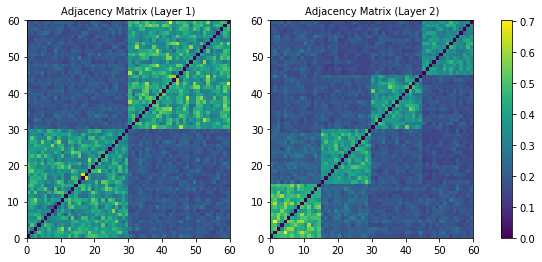

In [9]:
fig,ax = plt.subplots(1,layers, figsize = (5*layers,4))
for i in range(layers):
    k = ax[i].imshow(adjacency_matrices[i], 
                            origin = 'lower', 
                            interpolation='nearest', 
                            aspect='auto',  
                            extent = [0,num_neurons,0,num_neurons])
    ax[i].set_title('Adjacency Matrix (Layer %d)'%(i +1), fontsize = 10)
    ax[i].set_xticks([k*10 for k in range(int(num_neurons/10)+1)])
    ax[i].set_yticks([k*10 for k in range(int(num_neurons/10)+1)])
    ax[i].tick_params(axis = 'both', labelsize = 10)
cbar = fig.colorbar(k, ax = ax.flat)
cbar.ax.tick_params(labelsize = 10) 

## 6) Add edges to the infomap object and run infomap

In [22]:
im = Infomap("--two-level --directed")
for i,e in enumerate(adjacency_matrices):## list of length 2 corresponding to the adjacency matrices in each layer
    for j,f in enumerate(e):
        for k in range(len(f)):# f is each row of the adjacency matrix
            s = MultilayerNode(layer_id = i, node_id = j)
            t = MultilayerNode(layer_id = i, node_id = k)
            
            im.add_multilayer_link(s,t,f[k])

##diagonal coupling with interlayer coupling strength 1
for i in range(len(adjacency_matrices)-1):
    for j in range(num_neurons):# number of nodes which is 60 in the multilayer network
        s = MultilayerNode(layer_id = i, node_id = j)
        t = MultilayerNode(layer_id = i+1, node_id = j)
        im.add_multilayer_link(s, t, 0.00000000001)
im.run()

## 7) Results

In [23]:
print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

print("\n#layer_id node_id module_id:")
for node in im.nodes:
    print(f"{node.layer_id} {node.node_id} {node.module_id}")

Found 1 modules with codelength: 5.905860815647752

#layer_id node_id module_id:
0 59 1
0 58 1
0 47 1
0 50 1
0 42 1
0 41 1
0 38 1
0 30 1
0 35 1
0 37 1
0 10 1
0 46 1
0 44 1
0 33 1
0 34 1
0 20 1
0 45 1
0 2 1
0 40 1
0 25 1
0 1 1
0 9 1
0 13 1
0 0 1
0 57 1
0 49 1
0 53 1
0 18 1
0 26 1
0 32 1
0 31 1
0 4 1
0 19 1
0 23 1
0 51 1
0 22 1
0 39 1
0 12 1
0 15 1
0 36 1
0 24 1
0 56 1
0 27 1
0 55 1
0 52 1
0 5 1
0 14 1
0 8 1
0 3 1
0 17 1
0 21 1
0 6 1
0 43 1
0 16 1
1 4 1
0 28 1
0 29 1
0 7 1
1 9 1
1 1 1
0 48 1
0 54 1
1 6 1
1 5 1
1 2 1
1 13 1
1 8 1
0 11 1
1 0 1
1 11 1
1 10 1
1 14 1
1 19 1
1 28 1
1 7 1
1 3 1
1 23 1
1 12 1
1 15 1
1 26 1
1 25 1
1 20 1
1 27 1
1 33 1
1 24 1
1 37 1
1 40 1
1 41 1
1 18 1
1 22 1
1 16 1
1 17 1
1 21 1
1 36 1
1 54 1
1 32 1
1 29 1
1 30 1
1 44 1
1 43 1
1 31 1
1 48 1
1 55 1
1 35 1
1 53 1
1 51 1
1 52 1
1 34 1
1 42 1
1 50 1
1 46 1
1 59 1
1 38 1
1 58 1
1 45 1
1 47 1
1 56 1
1 39 1
1 49 1
1 57 1


## 8) utilize neighborhood flow coupling

In [35]:
from scipy.spatial.distance import jensenshannon
            
interlayers = []
for i in range(layers-1):
    layerweights = []
    for j in range(num_neurons):
        JSD = jensenshannon(adjacency_matrices[i][j,:], adjacency_matrices[i+1][j,:])
        if JSD > -1: layerweights.append(1 - JSD**2) ## for non NaNs
        else: layerweights.append(0)
# for NaNs assign an interlayer weight of 1, that is a higher dissimilarity in the JS divergence
    interlayers.append(layerweights)

In [36]:
im = Infomap("--two-level --directed")
for i,e in enumerate(adjacency_matrices):## list of length 2 corresponding to the adjacency matrices in each layer
    for j,f in enumerate(e):
        for k in range(len(f)):# f is each row of the adjacency matrix
            s = MultilayerNode(layer_id = i, node_id = j)
            t = MultilayerNode(layer_id = i, node_id = k)
            
            im.add_multilayer_link(s,t,f[k])

##diagonal coupling with interlayer coupling strength 1
for i in range(len(adjacency_matrices)-1):
    for j in range(num_neurons):# number of nodes which is 60 in the multilayer network
        s = MultilayerNode(layer_id = i, node_id = j)
        t = MultilayerNode(layer_id = i+1, node_id = j)
        im.add_multilayer_link(s, t, interlayers[i][j])
im.run()

In [37]:
print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

print("\n#layer_id node_id module_id:")
for node in im.nodes:
    print(f"{node.layer_id} {node.node_id} {node.module_id}")

Found 1 modules with codelength: 5.905645299488576

#layer_id node_id module_id:
1 4 1
1 9 1
1 1 1
1 6 1
1 5 1
1 2 1
1 13 1
1 8 1
1 0 1
1 11 1
1 10 1
1 14 1
1 19 1
1 28 1
1 7 1
1 3 1
1 23 1
1 12 1
1 15 1
1 26 1
1 25 1
1 20 1
1 27 1
1 33 1
1 24 1
1 37 1
1 40 1
1 41 1
1 18 1
1 22 1
1 16 1
1 17 1
1 21 1
1 36 1
1 54 1
1 32 1
1 29 1
1 30 1
1 44 1
1 43 1
1 31 1
1 48 1
1 55 1
1 35 1
1 53 1
1 51 1
1 52 1
1 34 1
1 42 1
1 50 1
1 46 1
1 59 1
1 38 1
1 58 1
1 45 1
1 47 1
1 56 1
1 39 1
1 49 1
1 57 1
0 59 1
0 58 1
0 47 1
0 50 1
0 42 1
0 41 1
0 38 1
0 30 1
0 35 1
0 37 1
0 46 1
0 44 1
0 10 1
0 33 1
0 34 1
0 20 1
0 45 1
0 2 1
0 40 1
0 25 1
0 1 1
0 9 1
0 13 1
0 0 1
0 57 1
0 49 1
0 53 1
0 18 1
0 26 1
0 32 1
0 31 1
0 4 1
0 19 1
0 23 1
0 51 1
0 22 1
0 39 1
0 12 1
0 15 1
0 36 1
0 24 1
0 56 1
0 27 1
0 55 1
0 52 1
0 5 1
0 14 1
0 8 1
0 3 1
0 17 1
0 21 1
0 6 1
0 43 1
0 16 1
0 28 1
0 29 1
0 7 1
0 48 1
0 54 1
0 11 1


In [38]:
interlayers

[[0.9837560609297552,
  0.9787764049682616,
  0.9809248129862534,
  0.980465346495032,
  0.9792118622109511,
  0.9834061294002308,
  0.9817819327807469,
  0.9847079531543514,
  0.978776879768864,
  0.978604218329684,
  0.9876885791930887,
  0.9849599709804409,
  0.9871648650942847,
  0.9856362079006818,
  0.982821887127985,
  0.982492359721734,
  0.9854501064782785,
  0.9849089815531314,
  0.9880010551197056,
  0.9850428072857091,
  0.986049475449229,
  0.9864050577889607,
  0.9879621241759957,
  0.9871451280984027,
  0.9876672985934897,
  0.9872652001137602,
  0.9844989833113734,
  0.987911779056573,
  0.9859131038175947,
  0.9843882536593245,
  0.9802935843564805,
  0.9836556905003204,
  0.9824253364326508,
  0.9809859733341468,
  0.978241921359353,
  0.9837812280992592,
  0.978832562817563,
  0.9776513600014173,
  0.9833075807164847,
  0.9847745168659255,
  0.982363530360609,
  0.9793053349670668,
  0.9770090640357935,
  0.9851968539371898,
  0.9762115616245037,
  0.9821662284628225